In [1]:
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [2]:
df = pd.read_csv('nba_elo.csv')
df.shape

(72039, 27)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72039 entries, 0 to 72038
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            72039 non-null  object 
 1   season          72039 non-null  int64  
 2   neutral         72039 non-null  int64  
 3   playoff         4626 non-null   object 
 4   team1           72039 non-null  object 
 5   team2           72039 non-null  object 
 6   elo1_pre        72039 non-null  float64
 7   elo2_pre        72039 non-null  float64
 8   elo_prob1       72039 non-null  float64
 9   elo_prob2       72039 non-null  float64
 10  elo1_post       72026 non-null  float64
 11  elo2_post       72026 non-null  float64
 12  carm-elo1_pre   5249 non-null   float64
 13  carm-elo2_pre   5249 non-null   float64
 14  carm-elo_prob1  5249 non-null   float64
 15  carm-elo_prob2  5249 non-null   float64
 16  carm-elo1_post  5249 non-null   float64
 17  carm-elo2_post  5249 non-null  

dropping rows for which we don't have scores

In [4]:
df = df.drop(df[df['score1'].isna()].index)

changes in league scoring system, from 2010 - only taking games from after then

In [5]:
as_datetime = pd.to_datetime(df['date'])

date_bound = pd.Timestamp('2010-01-01 00:00:00')

df.loc[:, 'date_as_dt'] = as_datetime
df.drop('date', axis=1)

df = df[df['date_as_dt'] > date_bound]
df = df.drop('date', axis=1)

df = df.reset_index().drop('index', axis=1)

In [6]:
df.shape

(16034, 27)

dropping duplicates in case there are any

In [7]:
df = df.drop_duplicates()

dropping features we don't want / need

In [8]:
df.columns

Index(['season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre',
       'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post',
       'carm-elo1_pre', 'carm-elo2_pre', 'carm-elo_prob1', 'carm-elo_prob2',
       'carm-elo1_post', 'carm-elo2_post', 'raptor1_pre', 'raptor2_pre',
       'raptor_prob1', 'raptor_prob2', 'score1', 'score2', 'quality',
       'importance', 'total_rating', 'date_as_dt'],
      dtype='object')

In [9]:
feats_to_drop = ['season', 'neutral', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post', 'carm-elo1_pre', 'carm-elo2_pre', 'carm-elo_prob1', 'carm-elo_prob2',
       'carm-elo1_post', 'carm-elo2_post', 'raptor1_pre', 'raptor2_pre',
       'raptor_prob1', 'raptor_prob2', 'quality',
       'importance', 'total_rating']

In [10]:
df = df.drop(feats_to_drop, axis=1)
df.shape

(16034, 8)

feature engineering target variable:
'team_won' => 1 means team1 is the winner, 2 means team2 is the winner

In [11]:
win_col_bool = (df.score1 < df.score2)
df['team_won'] = win_col_bool.astype('int') + 1
df = df.drop(['score1', 'score2'], axis=1)
df.shape

(16034, 7)

In [12]:
# win_col_bool = (df.score1 > df.score2)
# df['team_won'] = win_col_bool.astype('int')
# df = df.drop(['score1', 'score2'], axis=1)
# df.shape

transforming 'playoff' into binary feature

In [13]:
df['playoff'].unique()

array([nan, 't', 'q', 's', 'c', 'f', 'p'], dtype=object)

In [14]:
df['enc_playoff'] = df['playoff'].notna().astype(int)
df = df.drop('playoff', axis=1)
df.shape

(16034, 7)

making unique id now so that we can match it later

In [15]:
df['uid'] = df['team1'] + df['team2'] + df['date_as_dt'].astype('str')

preparing to add more features

In [16]:
df.date_as_dt = df.date_as_dt.astype(str)

In [17]:
team_abbrev_map = {'BOS': "Boston", 'IND': "Indiana", 'NJN': "Brooklyn", 'UTA': "Utah", 'POR': "Portland", 'PHO': "Phoenix", 'NOP': "New Orleans", 'MIA': "Miami", 'WAS': "Washington",
 'CHI': "Chicago", 'MIL': "Milwaukee", 'SAC': "Sacramento", 'CLE': "Cleveland", 'LAL': "LA Lakers", 'DEN': "Denver", 'NYK': "New York", 'TOR': "Toronto", 'LAC': "LA Clippers",
 'PHI': "Philadelphia", 'CHO': "Charlotte", 'DAL': "Dallas", 'MIN': "Minnesota", 'SAS': "San Antonio", 'OKC': "Okla City", 'ORL': "Orlando", 'ATL': "Atlanta", 'GSW': "Golden State",
 'MEM': "Memphis", 'HOU': "Houston", 'DET': "Detroit", 'BRK': "Brooklyn"}

# for abb in team_abbrev_map:
#     print(f"{abb}: {team_abbrev_map[abb]}")

In [18]:
df['team1'] = df['team1'].map(team_abbrev_map)
df['team2'] = df['team2'].map(team_abbrev_map)
df

,team1,team2,elo1_pre,elo2_pre,date_as_dt,team_won,enc_playoff,uid
0,Boston,Toronto,1660.570200,1496.282300,2010-01-02,1,0,BOSTOR2010-01-02
1,Indiana,Minnesota,1374.847800,1304.970300,2010-01-02,1,0,INDMIN2010-01-02
2,Brooklyn,Cleveland,1302.088900,1742.092500,2010-01-02,2,0,NJNCLE2010-01-02
3,Utah,Denver,1560.920000,1598.805400,2010-01-02,2,0,UTADEN2010-01-02
4,Portland,Golden State,1574.627400,1397.983900,2010-01-02,1,0,PORGSW2010-01-02
...,...,...,...,...,...,...,...,...
16029,Milwaukee,Boston,1631.037053,1722.739869,2022-05-13,2,1,MILBOS2022-05-13
16030,Golden State,Memphis,1629.192597,1647.657708,2022-05-13,1,1,GSWMEM2022-05-13
16031,Boston,Milwaukee,1735.369036,1618.407885,2022-05-15,1,1,BOSMIL2022-05-15
16032,Phoenix,Dallas,1650.983771,1628.637291,2022-05-15,2,1,PHODAL2022-05-15


adding defense features

In [19]:
# defensive
df_def = pd.read_csv('def_extra_info.csv')

adding defense features

In [20]:
try_merge = df.merge(df_def, left_on = ['team1', 'date_as_dt'], right_on=['Team', 'date'], how='left')
df = try_merge.merge(df_def, left_on = ['team2', 'date_as_dt'], right_on=['Team', 'date'], how='left', suffixes=('_defend1', '_defend2'))

adding offense features

In [21]:
# offensive
df_off = pd.read_csv('off_extra_info.csv')

In [22]:
try_merge = df.merge(df_off, left_on = ['team1', 'date_as_dt'], right_on=['Team', 'date'], how='left')
df = try_merge.merge(df_off, left_on = ['team2', 'date_as_dt'], right_on=['Team', 'date'], how='left', suffixes=('_offense1', '_offense2'))


In [23]:
new_feats_to_drop = ['Team_defend1', 'Team_defend2', 'Team_offense1', 'Team_offense2', 'date_defend1', 'date_defend2', 'date_offense1', 'date_offense2']

In [24]:
df = df.drop(new_feats_to_drop, axis=1)
df.shape

(16034, 24)

In [25]:
df = df.dropna()
df.shape

(16025, 24)

adding odds as features

In [26]:
df_odds = pd.read_csv('historical_odds.csv')

In [27]:
df_odds.shape

(33018, 5)

In [28]:
df_odds.head()

,Unnamed: 0,Date,Team,ML,Prob
0,0,2009-10-27,Boston,170.0,0.370370
1,1,2009-10-27,Cleveland,-200.0,0.666667
2,2,2009-10-27,Washington,320.0,0.238095
3,3,2009-10-27,Dallas,-400.0,0.800000
4,4,2009-10-27,Houston,400.0,0.200000


In [29]:
df_odds.columns

Index(['Unnamed: 0', 'Date', 'Team', 'ML', 'Prob'], dtype='object')

In [30]:
df_odds = df_odds.drop('Unnamed: 0', axis=1)
df_odds.head()

,Date,Team,ML,Prob
0,2009-10-27,Boston,170.0,0.370370
1,2009-10-27,Cleveland,-200.0,0.666667
2,2009-10-27,Washington,320.0,0.238095
3,2009-10-27,Dallas,-400.0,0.800000
4,2009-10-27,Houston,400.0,0.200000


In [31]:
df_odds.shape

(33018, 4)

In [32]:
df_odds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33018 entries, 0 to 33017
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    33018 non-null  object 
 1   Team    33016 non-null  object 
 2   ML      33018 non-null  float64
 3   Prob    33018 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.0+ MB


In [33]:
df_odds = df_odds.dropna()
df_odds.shape

(33016, 4)

merging with our dataframe

In [34]:
try_merge = df.merge(df_odds, left_on = ['team1', 'date_as_dt'], right_on=['Team', 'Date'], how='left')
df = try_merge.merge(df_odds, left_on = ['team2', 'date_as_dt'], right_on=['Team', 'Date'], how='left', suffixes=('_odds1', '_odds2'))


In [35]:
df.head()

,team1,team2,elo1_pre,elo2_pre,date_as_dt,team_won,enc_playoff,uid,Last 3_defend1,Last 1_defend1,...,Home_offense2,Away_offense2,Date_odds1,Team_odds1,ML_odds1,Prob_odds1,Date_odds2,Team_odds2,ML_odds2,Prob_odds2
0,Boston,Toronto,1660.5702,1496.2823,2010-01-02,1,0,BOSTOR2010-01-02,1.063,1.187,...,1.082,1.078,2010-01-02,Boston,-155.0,0.607843,2010-01-02,Toronto,135.0,0.425532
1,Indiana,Minnesota,1374.8478,1304.9703,2010-01-02,1,0,INDMIN2010-01-02,1.105,1.169,...,0.956,0.974,2010-01-02,Indiana,-190.0,0.655172,2010-01-02,Minnesota,165.0,0.377358
2,Brooklyn,Cleveland,1302.0889,1742.0925,2010-01-02,2,0,NJNCLE2010-01-02,1.058,0.987,...,1.097,1.05,2010-01-02,Brooklyn,450.0,0.181818,2010-01-02,Cleveland,-600.0,0.857143
3,Utah,Denver,1560.9200,1598.8054,2010-01-02,2,0,UTADEN2010-01-02,0.918,0.909,...,1.129,1.043,2010-01-02,Utah,-320.0,0.761905,2010-01-02,Denver,260.0,0.277778
4,Portland,Golden State,1574.6274,1397.9839,2010-01-02,1,0,PORGSW2010-01-02,1.109,1.054,...,1.055,1.061,2010-01-02,Portland,-155.0,0.607843,2010-01-02,Golden State,135.0,0.425532


In [36]:
odds_feats_to_drop = ['Date_odds1', 'Team_odds1', 'Date_odds2', 'Team_odds2']

In [37]:
df = df.drop(odds_feats_to_drop, axis=1)
df.shape

(16026, 28)

In [38]:
df = df.dropna()
df.shape

(16010, 28)

In [39]:
df.columns

Index(['team1', 'team2', 'elo1_pre', 'elo2_pre', 'date_as_dt', 'team_won',
       'enc_playoff', 'uid', 'Last 3_defend1', 'Last 1_defend1',
       'Home_defend1', 'Away_defend1', 'Last 3_defend2', 'Last 1_defend2',
       'Home_defend2', 'Away_defend2', 'Last 3_offense1', 'Last 1_offense1',
       'Home_offense1', 'Away_offense1', 'Last 3_offense2', 'Last 1_offense2',
       'Home_offense2', 'Away_offense2', 'ML_odds1', 'Prob_odds1', 'ML_odds2',
       'Prob_odds2'],
      dtype='object')

creating game results for opposing teams

In [40]:
df2 = df.copy()
# switching team names
df2['team1'] = df['team2']
df2['team2'] = df['team1']

# switching defense
df2['Last 3_defend1'] = df['Last 3_defend2']
df2['Last 3_defend2'] = df['Last 3_defend1']
df2['Last 1_defend1'] = df['Last 1_defend2']
df2['Last 1_defend2'] = df['Last 1_defend1']
df2['Home_defend1'] = df['Home_defend2']
df2['Home_defend2'] = df['Home_defend1']
df2['Away_defend1'] = df['Away_defend2']
df2['Away_defend2'] = df['Away_defend1']

# switching offense
df2['Last 3_offense1'] = df['Last 3_offense2']
df2['Last 1_offense1'] = df['Last 1_offense2']
df2['Home_offense1'] = df['Home_offense2']
df2['Away_offense1'] = df['Away_offense2']
df2['Last 3_offense2'] = df['Last 3_offense1']
df2['Last 1_offense2'] = df['Last 1_offense1']
df2['Home_offense2'] = df['Home_offense1']
df2['Away_offense2'] = df['Away_offense1']

# switching odds
df2['ML_odds1'] = df['ML_odds2']
df2['ML_odds2'] = df['ML_odds1']
df2['Prob_odds1'] = df['Prob_odds2']
df2['Prob_odds2'] = df['Prob_odds1']

# switching team elos
df2['elo_1_pre'] = df['elo2_pre']
df2['elo_2_pre'] = df['elo1_pre']
df2['elo1_pre'] = df2['elo_1_pre']
df2['elo2_pre'] = df2['elo_2_pre']
df2 = df2.drop(['elo_1_pre', 'elo_2_pre'], axis=1)
# switching team win
df2['team_won'] = (df2['team_won'] == 1).astype(int) + 1
# adding uids
df2['uid'] = df['uid']

In [41]:
df = pd.concat([df, df2], axis=0)
df.shape

(32020, 28)

In [42]:
df = df.drop_duplicates()

splitting data into train and test according to date

In [43]:
as_datetime = pd.to_datetime(df['date_as_dt'])

df.loc[:, 'date_as_dt'] = as_datetime

date_bound = pd.Timestamp('2018-01-01 00:00:00')
train = df[df['date_as_dt'] < date_bound]
test = df[~(df['date_as_dt'] < date_bound)]

train.shape, test.shape

((20632, 28), (11388, 28))

In [44]:
X_train = train.drop('team_won', axis=1)
y_train = train['team_won']

X_test = test.drop('team_won', axis=1)
y_test = test['team_won']

X_train = X_train.reset_index().drop('index', axis=1)
X_test = X_test.reset_index().drop('index', axis=1)
y_train = y_train.reset_index()['team_won']
y_test = y_test.reset_index()['team_won']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20632, 27), (11388, 27), (20632,), (11388,))

In [45]:
X_train.shape[0] / df.shape[0], X_test.shape[0] / df.shape[0]

(0.6443472829481574, 0.3556527170518426)

extracting uids, pobability odds, and money line odds for later

In [46]:
x_test_probs1 = X_test['Prob_odds1'].copy()
x_test_probs2 = X_test['Prob_odds2'].copy()
x_test_ml1 = X_test['ML_odds1'].copy()
x_test_ml2 = X_test['ML_odds2'].copy()

x_test_uids = X_test['uid'].copy()
X_test = X_test.drop('uid', axis=1)
X_train = X_train.drop('uid', axis=1)

label encoding team names

In [47]:
cols = ['team1', 'team2']
# saving team names for results:
x_train_team_names = X_train[cols].copy()
x_test_team_names = X_test[cols].copy()

In [48]:
le = LabelEncoder()
le.fit(X_train['team1'])

X_test['team1'] = X_test['team1'].map(lambda s: '<unknown>' if s not in le.classes_ else s)
X_test['team2'] = X_test['team2'].map(lambda s: '<unknown>' if s not in le.classes_ else s)

le.classes_ = np.append(le.classes_, '<unknown>')

X_train['enc_team1'] = le.transform(X_train['team1'])
X_train['enc_team2'] = le.transform(X_train['team2'])
X_test['enc_team1'] = le.transform(X_test['team1'])
X_test['enc_team2'] = le.transform(X_test['team2'])

X_train = X_train.drop(cols, axis=1)
X_test = X_test.drop(cols, axis=1)
X_train.shape, X_test.shape

((20632, 26), (11388, 26))

getting rid of invalid values

In [49]:
ob_cols = ['Last 3_defend1',
       'Last 1_defend1', 'Home_defend1', 'Away_defend1', 'Last 3_defend2',
       'Last 1_defend2', 'Home_defend2', 'Away_defend2', 'Last 3_offense1',
       'Last 1_offense1', 'Home_offense1', 'Away_offense1', 'Last 3_offense2',
       'Last 1_offense2', 'Home_offense2', 'Away_offense2']
for col in ob_cols:
    train_bad_samps = X_train[X_train[col] == '--'].index
    X_train = X_train.drop(train_bad_samps, axis=0)
    y_train = y_train.drop(train_bad_samps, axis=0)
for col in ob_cols:
    test_bad_samps = X_test[X_test[col] == '--'].index
    X_test = X_test.drop(test_bad_samps, axis=0)
    y_test = y_test.drop(test_bad_samps, axis=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19920, 26), (11052, 26), (19920,), (11052,))

turning datetime into integer in order to put into model

In [50]:
x_train_dates = X_train['date_as_dt'].copy()
x_test_dates = X_test['date_as_dt'].copy()
X_train['date_as_dt'] = X_train['date_as_dt'].apply(lambda x: x.value) / 10**9
X_test['date_as_dt'] = X_test['date_as_dt'].apply(lambda x: x.value) / 10**9

In [51]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_ss = scaler.transform(X_train)
X_test_ss = scaler.transform(X_test)


X_train = pd.DataFrame(data=X_train_ss, columns=X_train.columns)
X_test = pd.DataFrame(data=X_test_ss, columns=X_test.columns)
X_train.shape, X_test.shape

((19920, 26), (11052, 26))

baseline model 1

In [52]:
from sklearn.linear_model import LogisticRegression
import pickle
lr = LogisticRegression()
lr.fit(X_train, y_train)
with open('model.pkl', 'wb') as model_file:
    pickle.dump(lr, model_file, protocol=pickle.HIGHEST_PROTOCOL)

In [53]:
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.68      0.68      0.68      5526
           2       0.68      0.68      0.68      5526

    accuracy                           0.68     11052
   macro avg       0.68      0.68      0.68     11052
weighted avg       0.68      0.68      0.68     11052



extracting results

In [54]:
X_test.columns

Index(['elo1_pre', 'elo2_pre', 'date_as_dt', 'enc_playoff', 'Last 3_defend1',
       'Last 1_defend1', 'Home_defend1', 'Away_defend1', 'Last 3_defend2',
       'Last 1_defend2', 'Home_defend2', 'Away_defend2', 'Last 3_offense1',
       'Last 1_offense1', 'Home_offense1', 'Away_offense1', 'Last 3_offense2',
       'Last 1_offense2', 'Home_offense2', 'Away_offense2', 'ML_odds1',
       'Prob_odds1', 'ML_odds2', 'Prob_odds2', 'enc_team1', 'enc_team2'],
      dtype='object')

In [55]:
print(y_pred[:20])
print(y_test[:20].values)
print((y_pred == y_test).astype(int)[:20].values)

[1 1 1 1 1 2 1 2 1 2 1 1 2 1 2 1 1 2 1 1]
[1 1 1 2 1 2 1 2 1 2 1 1 1 1 2 1 1 2 2 1]
[1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1]


In [56]:
results = X_test.copy()

results['y_pred'] = y_pred

our_results_correct = (y_pred == y_test).astype(int)
results['our_results_correct'] = our_results_correct

proba = lr.predict_proba(X_test)
results[['prob1', 'prob2']] = proba

extra features for results

In [57]:
# columns needed for calculation:

results['uid'] = x_test_uids
results[['team1', 'team2']] = x_test_team_names
results['Prob_odds1_org'] = x_test_probs1
results['Prob_odds2_org'] = x_test_probs2
results['ML_odds1_org'] = x_test_ml1
results['ML_odds2_org'] = x_test_ml2
results['date'] = x_train_dates

calculating our predicted odds

In [58]:
def cal_ml(row):
    if row['y_pred'] == 1:
        return row['ML_odds1_org']
    if row['y_pred'] == 2:
        return row['ML_odds2_org']

In [59]:
results['odds_for_bet'] = results.apply(cal_ml, axis=1)
results.T

,0,1,2,3,4,5,6,7,8,9,...,11042,11043,11044,11045,11046,11047,11048,11049,11050,11051
elo1_pre,-0.573441,1.033409,0.403078,-0.376646,0.891137,-0.452891,-1.259928,-1.293536,0.084175,-1.379976,...,1.077397,0.967625,0.937282,1.178704,1.201622,1.348974,1.8222,1.171525,0.918041,1.006691
elo2_pre,-1.358938,-0.011281,-1.185517,-0.147879,-0.077485,0.808453,-0.939115,-0.496483,-0.752815,1.038433,...,1.05889,1.239416,1.912406,1.004325,0.934665,0.858066,1.027488,1.011503,1.931647,1.200349
date_as_dt,1.713363,1.713363,1.713363,1.713363,1.714538,1.714538,1.714538,1.714538,1.714538,1.715712,...,3.580693,3.580693,3.581867,3.581867,3.583042,3.583042,3.584216,3.584216,3.586565,3.586565
enc_playoff,-0.267477,-0.267477,-0.267477,-0.267477,-0.267477,-0.267477,-0.267477,-0.267477,-0.267477,-0.267477,...,3.738642,3.738642,3.738642,3.738642,3.738642,3.738642,3.738642,3.738642,3.738642,3.738642
Last 3_defend1,0.222453,0.396093,0.671022,-0.356347,0.902542,0.019873,0.569732,1.452402,-0.732566,0.121163,...,0.396093,1.249822,0.656552,-0.558926,0.150103,-0.023537,0.425033,0.468443,1.220882,0.034343
Last 1_defend1,0.230694,-0.634831,-0.807936,0.841117,0.18514,-0.252178,1.187327,1.005111,-0.662163,-0.343285,...,0.403799,0.139586,1.032443,-0.981041,-1.518577,-1.764568,1.014222,-1.154146,0.494907,-1.217921
Home_defend1,1.167414,-0.638585,1.464604,-0.135648,1.738933,0.252984,1.441743,1.075971,0.847364,0.824503,...,1.396022,0.664478,1.32744,0.024377,0.870225,0.778782,0.687339,0.573035,1.3503,0.595896
Away_defend1,0.513727,-0.006234,0.631899,1.435475,0.750072,0.702803,1.15186,1.695455,0.560996,1.364571,...,0.986418,1.317302,1.033687,0.750072,0.442823,0.442823,0.017401,0.750072,1.033687,1.340936
Last 3_defend2,0.511852,-0.009067,2.016731,-0.269527,0.555262,-0.139297,-0.472107,-0.038007,1.466872,1.061712,...,0.989362,1.191942,-0.732566,0.714432,0.497382,0.540792,0.569732,0.743372,0.338213,0.381623
Last 1_defend2,2.007298,-0.115516,1.588201,0.440242,0.321802,-0.388839,-0.981041,0.057589,-0.643941,1.141773,...,1.123551,1.087108,0.312691,-0.716828,1.733974,1.10533,0.731787,2.244178,-0.698606,1.360432


In [60]:
# results[(results['team1'] == 'Brooklyn') & (results['team2'] == 'Orlando')].T

In [61]:
# results[(results['team1'] == 'Orlando') & (results['team2'] == 'Brooklyn')].T

calculating profit in dollars 🤑

In [62]:
# results['our_results_correct'] * results['ML_odds1']
results['odds_multiplied'] = results.our_results_correct * results.odds_for_bet
results['profit_on_$100'] = results['odds_multiplied'].apply(lambda x: -100 if x==0 else ((100 * (100 / abs(x))) if x < 0 else x))

results[['ML_odds1',
       'Prob_odds1', 'ML_odds2', 'Prob_odds2',
       'y_pred', 'our_results_correct', 'prob1', 'prob2',
       'odds_for_bet', 'odds_multiplied',
       'profit_on_$100']].sample(20)

,ML_odds1,Prob_odds1,ML_odds2,Prob_odds2,y_pred,our_results_correct,prob1,prob2,odds_for_bet,odds_multiplied,profit_on_$100
471,0.347375,-0.581647,-0.171413,0.591536,2,1.0,0.370899,0.629101,-190.0,-190.0,52.631579
4464,-1.149698,1.630330,0.962509,-1.607010,1,1.0,0.852748,0.147252,-165.0,-165.0,60.606061
6201,-0.186235,0.641378,0.362198,-0.643416,1,1.0,0.658826,0.341174,300.0,300.0,300.000000
4670,-0.482685,1.219534,0.599358,-1.240994,1,1.0,0.777239,0.222761,-130.0,-130.0,76.923077
2643,-0.349283,1.029166,0.480778,-1.010499,1,0.0,0.715077,0.284923,-290.0,-0.0,-100.000000
8264,-0.201058,0.688003,0.369609,-0.672615,1,0.0,0.657940,0.342060,-750.0,-0.0,-100.000000
542,-1.223811,1.653152,0.999565,-1.629953,1,1.0,0.853383,0.146617,-900.0,-900.0,11.111111
7952,0.325141,-0.479539,-0.141768,0.480778,2,1.0,0.391969,0.608031,-330.0,-330.0,30.303030
4498,0.317730,-0.442667,-0.126945,0.419009,2,0.0,0.364387,0.635613,-210.0,-0.0,-100.000000
10921,0.362198,-0.643416,-0.171413,0.591536,2,0.0,0.370326,0.629674,165.0,0.0,-100.000000


In [63]:
results['our_results_correct'].mean()

0.6759051885031728

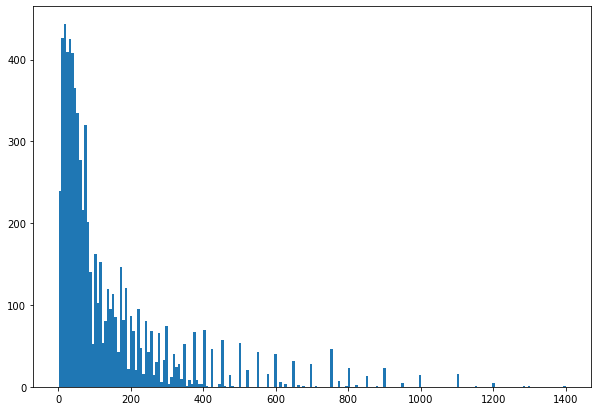

In [64]:
results[results['our_results_correct'] == 1][['ML_odds1',
       'Prob_odds1', 'ML_odds2', 'Prob_odds2',
       'y_pred', 'our_results_correct', 'prob1', 'prob2',
       'odds_for_bet', 'odds_multiplied',
       'profit_on_$100']]
plt.figure(figsize=(10, 7))
plt.hist('profit_on_$100', data=results[results['our_results_correct'] == 1], bins=200)
plt.show()

<BarContainer object of 26 artists>

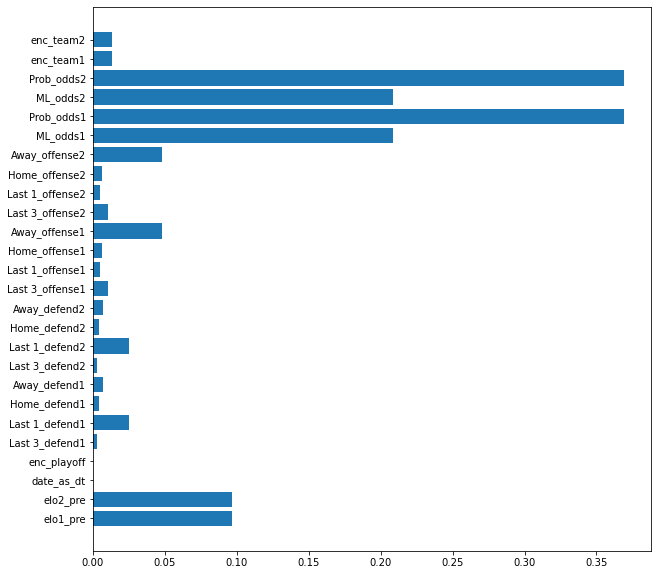

In [65]:
coeff = abs(lr.coef_)
feats = lr.feature_names_in_
plt.figure(figsize=(10, 10))
plt.barh(feats.ravel(), coeff.ravel())

Profit to be made!

In [66]:
amount_wagered = 100 * len(results)
tot_profit = results['profit_on_$100'].sum()

print(f"How much we wagered: {amount_wagered}")
print(f"Profit: {tot_profit:.2f}")
print(f"Average Profit Pct: {(tot_profit / amount_wagered) * 100:.2f}%")

How much we wagered: 1105200
Profit: 671091.73
Average Profit Pct: 60.72%


In [67]:
results['profit_on_$100'].mean()

62.625208346075254

In [68]:
results['profit_on_$100'].value_counts()

-100.000000     3473
 76.923077       136
 50.000000       122
 52.631579       117
 58.823529       117
                ... 
 1284.000000       1
 1300.000000       1
 28.169014         1
 226.000000        1
 207.000000        1
Name: profit_on_$100, Length: 253, dtype: int64

In [69]:
# with open('x_test_preds.csv', 'w') as x_test_preds_file:
#     results.to_csv(x_test_preds_file, index=False, sep=',')

# as_datetime = pd.to_datetime(results['date'])
# results.loc[:, 'date'] = as_datetime

# with open('games.csv', 'w') as games_file:
#     games = results[['uid', 'team1', 'team2', 'date']].iloc[100:]
#     games.to_csv(games_file, index=False, sep=',')

# with open('bets.csv', 'w') as bets_file:
#     bets = results[['uid', 'team1', 'ML_odds1_org', 'Prob_odds1_org', 'prob1']].iloc[100:]
#     bets.to_csv(bets_file, index=False, sep=',')

In [70]:
# def cal_ours_better_odds(row):
#     if row['y_pred'] == 1:
#         odds_better1 = row['prob1'] > row['Prob_odds1']
#         return odds_better1
#     if row['y_pred'] == 2:
#         odds_better2 = row['prob2'] > row['Prob_odds2']
#         return odds_better2

In [71]:
# results['ours_better_odds'] = results.apply(cal_ours_better_odds, axis=1)